# Paws and Prediction
## Overview of the project
0. Import libraries
1. Load and transform data
2. Visualize data
3. Train Class to initialize all training

\\


## Misc
- Loss function: Cross Entropy :https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

- Optimizer? Adam optimizer

\\

## To explore for multi-class classification problem:
1. Fine-tuning more layers (compared to just the final layer, and then incrementally increasing the number of layers fine-tuned).
2. Different learning rates and/or learning rate schedulers for different layers.
3. Benefit of applying data augmentations (flip, small rotations, crops, small size scaling).
4. Effect of fine-tuning or not the batch-norm parameters and updating the estimate of the batch mean and standard deviations on the final performance on the new dataset.

In [ ]:
import torch
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
from torchvision.transforms.functional import InterpolationMode
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torchvision.transforms import RandomApply

from tqdm import tqdm
import time
from sklearn.metrics import classification_report

In [ ]:
## for gpu usage, check true
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


## 1. Load and transform data

We might want to think about how we transform the data and the splitting
Also about the size (now [3, 384, 384]), will probably require a lot of compute to train? Look up what seems reasonable

""The inference transforms are available at EfficientNet_B4_Weights.IMAGENET1K_V1.transforms and perform the following preprocessing operations: Accepts PIL.Image, batched (B, C, H, W) and single (C, H, W) image torch.Tensor objects. The images are resized to resize_size=[384] using interpolation=InterpolationMode.BICUBIC, followed by a central crop of crop_size=[380]. Finally the values are first rescaled to [0.0, 1.0] and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].""


####ser ut som att man kan addera random augmentations :))

def get_train_transform(IMAGE_SIZE, pretrained):
    train_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
        transforms.ToTensor(),
        normalize_transform(pretrained)
    ])
    retur

In [ ]:
from torch.utils.data import Dataset

class TrDataset(Dataset):
    def __init__(self, base_dataset, transformations):
        super(TrDataset, self).__init__()
        self.base = base_dataset
        self.transformations = transformations

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        x, y = self.base[idx]
        return self.transformations(x), y



class LoadData:
    def __init__(self):
        self.dataset_trainval = None
        self.test_dataset = None

        self.transform_images()
        self.mult_dataset()

        self.classes, self.class_labels = self.get_classes()

        #self.data_loaders()

    def get_classes(self):
        if self.dataset_trainval is not None:
            dataset = self.dataset_trainval
        else:
            dataset = OxfordIIITPet(root='./data', download=True, split = "trainval")

        class_labels = dataset.classes
        class_labels_dict = {}

        for i, breed in enumerate(class_labels):
            class_labels_dict[i] = breed

        return len(class_labels), class_labels_dict


    def mult_dataset(self):
        """Load the multclass dataset"""

        self.dataset_trainval = OxfordIIITPet(root='./data', download=True, split = "trainval")
        self.test_dataset = OxfordIIITPet(root='./data', transform=self.transform, download=True, split = "test")

        return

    def data_loaders(self, batch_size=16, split_ratio=0.8):
        """Initialize dataloaders"""

        train_size = int(split_ratio * len(self.dataset_trainval))
        val_size = len(self.dataset_trainval) - train_size

        train_dataset, val_dataset = random_split(self.dataset_trainval, [train_size, val_size])
        train_dataset = TrDataset(train_dataset, self.transforms_aug)
        val_dataset = TrDataset(val_dataset, self.transform)

        self.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) #later add number of workers
        self.val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
        self.test_loader = DataLoader(self.test_dataset, batch_size=batch_size, shuffle=True)

        return


    def transform_images(self):
        self.transforms_aug = transforms.Compose([
                        transforms.RandomHorizontalFlip(p=0.5), #random flip
                        transforms.RandomApply([transforms.RandomRotation((-15, 15))], p=0.5), #random rotation
                        transforms.RandomApply([transforms.RandomResizedCrop(380, scale=(0.5, 1.0), ratio=(0.5, 1.5))], p=0.5), #random resizing
                        transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))], p=0.5), #random translation
                        transforms.Resize(384, interpolation=InterpolationMode.BICUBIC),
                        transforms.CenterCrop(380),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                        ])

        self.transform = transforms.Compose([
                        transforms.Resize(384, interpolation=InterpolationMode.BICUBIC),
                        transforms.CenterCrop(380),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                        ])
        return




In [ ]:
sizes = {
            'b0': (256, 224), 'b1': (256, 240), 'b2': (288, 288), 'b3': (320, 300),
            'b4': (384, 380), 'b5': (489, 456), 'b6': (561, 528), 'b7': (633, 600),
        }

## 2. Visualize Data with Augmentations
Augmentations done:
- random cropping
- random rotation
- random translations
- random flipping
(also scaled to a smaller size for efficiency)

### a) Visualize what the different augmentations do

In [ ]:
transform = transforms.Compose([
                transforms.Resize(230, interpolation=InterpolationMode.BICUBIC),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                ])

transforms_with_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.99), #random flip
    transforms.RandomApply([transforms.RandomRotation((-15, 15))], p=0.99), #random rotation
    transforms.RandomApply([transforms.RandomResizedCrop(380, scale=(0.5, 1.0), ratio=(0.5, 1.5))], p=0.99), #random resizing
    transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))], p=0.99), #random translation
    transforms.Resize(384, interpolation=InterpolationMode.BICUBIC),
    transforms.CenterCrop(380),
    transforms.ToTensor(),
])


In [ ]:
dataset = OxfordIIITPet(root='./data', download=True, split = "trainval")

random_indices = np.random.choice(len(dataset), 10)


100%|██████████| 791918971/791918971 [00:04<00:00, 183624684.51it/s]


Extracting data/oxford-iiit-pet/images.tar.gz to data/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:00<00:00, 114100377.34it/s]


Extracting data/oxford-iiit-pet/annotations.tar.gz to data/oxford-iiit-pet


In [ ]:
class_labels = dataset.classes
class_labels_dict = {}

for i, breed in enumerate(class_labels):
    class_labels_dict[i] = breed

print(class_labels_dict)

{0: 'Abyssinian', 1: 'American Bulldog', 2: 'American Pit Bull Terrier', 3: 'Basset Hound', 4: 'Beagle', 5: 'Bengal', 6: 'Birman', 7: 'Bombay', 8: 'Boxer', 9: 'British Shorthair', 10: 'Chihuahua', 11: 'Egyptian Mau', 12: 'English Cocker Spaniel', 13: 'English Setter', 14: 'German Shorthaired', 15: 'Great Pyrenees', 16: 'Havanese', 17: 'Japanese Chin', 18: 'Keeshond', 19: 'Leonberger', 20: 'Maine Coon', 21: 'Miniature Pinscher', 22: 'Newfoundland', 23: 'Persian', 24: 'Pomeranian', 25: 'Pug', 26: 'Ragdoll', 27: 'Russian Blue', 28: 'Saint Bernard', 29: 'Samoyed', 30: 'Scottish Terrier', 31: 'Shiba Inu', 32: 'Siamese', 33: 'Sphynx', 34: 'Staffordshire Bull Terrier', 35: 'Wheaten Terrier', 36: 'Yorkshire Terrier'}


In [ ]:
images = []
images_aug = []
labels = []
random_indices = np.random.choice(len(dataset), 10)
for index in random_indices:
    img, lab = dataset[index]
    images.append(transform(img))
    images_aug.append(transforms_with_augmentation(img))
    labels.append(lab)

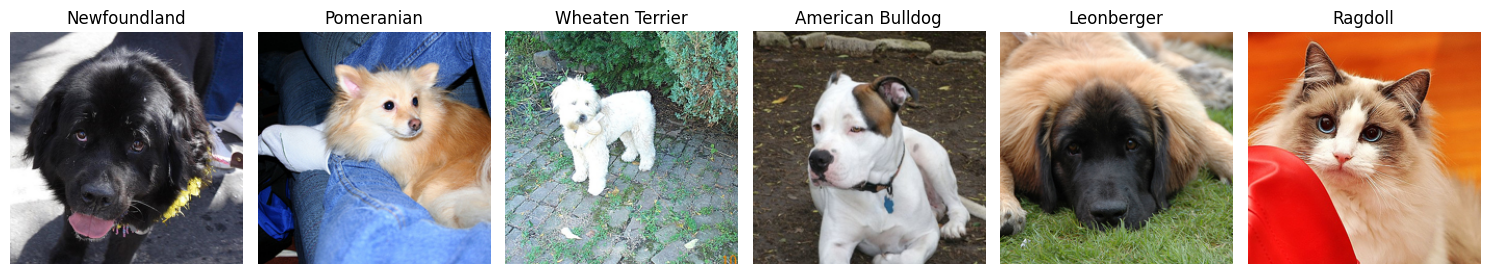

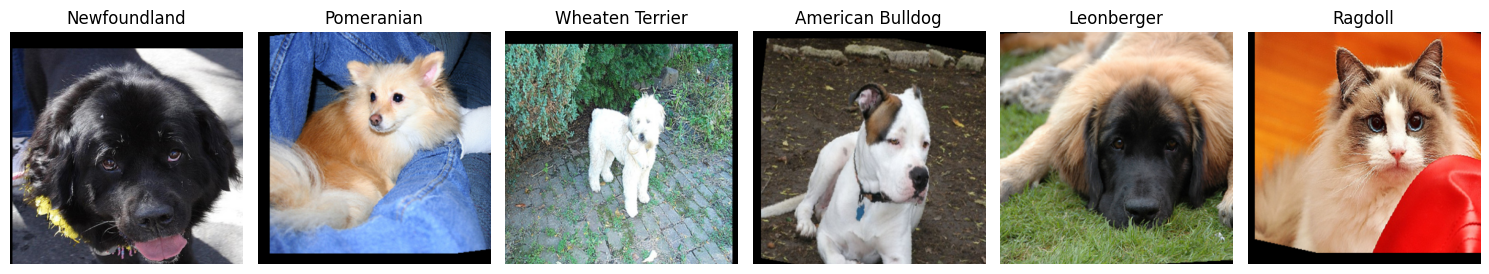

In [ ]:
plt.figure(figsize=(15, 3))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.title(f'{class_labels_dict[labels[i]]}')
    plt.axis('off')
plt.tight_layout()
plt.savefig('normal_img.png', dpi = 600)
plt.show()

plt.figure(figsize=(15, 3))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(images_aug[i].permute(1, 2, 0))
    plt.title(f'{class_labels_dict[labels[i]]}')
    plt.axis('off')
plt.tight_layout()
plt.savefig('aug_img.png', dpi = 600)
plt.show()

### b) Visualize that the image will have different augmentations each time

In [ ]:

transforms_with_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), #random flip
    transforms.RandomApply([transforms.RandomRotation((-30, 30))], p=0.5), #random rotation
    transforms.RandomApply([transforms.RandomResizedCrop(230, scale=(0.5, 1.0), ratio=(0.5, 1.5))], p=0.5), #random resizing
    transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))], p=0.5), #random translation
    transforms.Resize(230, interpolation=InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
dataset = OxfordIIITPet(root='./data',download=True, split = "trainval")

from torch.utils.data import Subset
first_image_idx = 0
subset = Subset(dataset, [first_image_idx])
subset = TrDataset(subset, transforms_with_augmentation)
imgs_loader = DataLoader(subset, batch_size=1, shuffle=True)

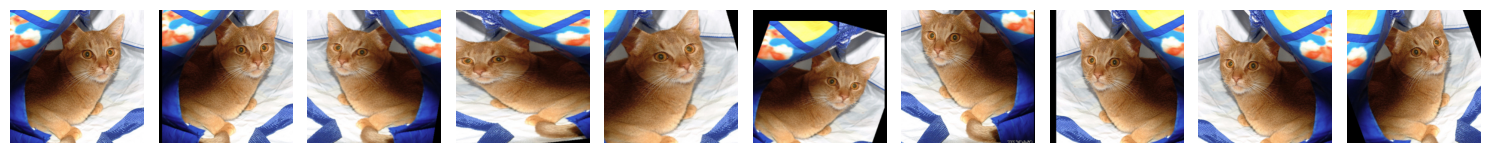

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'imgs' is a DataLoader object containing image tensors
plt.figure(figsize=(15, 15))
for i in range(10):
  for img, lab in imgs_loader:
    plt.subplot(1, 10, i + 1)
    plt.imshow(img[0].permute(1, 2, 0))
    plt.axis('off')
plt.tight_layout()
plt.show()


## 3. Load Model Class

In [ ]:
class Model(nn.Module):
    def __init__(self, train, num_classes):
        super(Model, self).__init__()
        self.train = train
        self.model = models.efficientnet_b4(weights = models.EfficientNet_B4_Weights.IMAGENET1K_V1)

        #self.model = models.efficientnet_b7(weights = models.EfficientNet_B7_Weights.IMAGENET1K_V1)

        for param in self.model.parameters():
            param.requires_grad = False

        num_features = self.model.classifier[1].in_features
        self.model.classifier[1] = nn.Linear(num_features, num_classes, bias=True) #do we want to have a bias term?

        """
        self.model.classifier = nn.Sequential(
            nn.BatchNorm1d(num_features),
            #nn.Linear(num_features, 512),
            #nn.ReLU(inplace=True),
            #nn.Linear(512, 256),
            #nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(num_features, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes)
        )
        """

    def unfreeze_bn_layers(self, model):
        def find_bn_layers(model):
            bn_layers = []
            for name, child in model.named_children():
                if isinstance(child, nn.BatchNorm2d):
                    for param in child.parameters():
                        param.requires_grad = True
                        bn_layers.append(param)
                else:
                    bn_layers.extend(find_bn_layers(child))
            return bn_layers

        bn_layers = find_bn_layers(self.model)
        bn_lr = self.train.lr
        self.train.optimizer.add_param_group({'params': bn_layers, 'lr': bn_lr})
        return


    def unfreeze_blocks(self):
        """Unfreezes the next layers in a predefined order by self.layers_to_finetune"""

        if self.train.lvl_of_unfrozen_layers >= len(self.train.layers_to_finetune):
            return

        new_params = []

        for name, param in self.train.layers_to_finetune[self.train.lvl_of_unfrozen_layers].named_parameters():
            if param.requires_grad == False:
                param.requires_grad = True
                new_params.append(param)

        self.train.optimizer.add_param_group({'params': new_params, 'lr': self.train.lr_per_layer[self.train.lvl_of_unfrozen_layers]})
        self.train.lvl_of_unfrozen_layers += 1
        return


    def forward(self, x):
        return self.model(x)


## 4. Train Class to initialize all training

In [ ]:
#todo - add training and validation accuracy
#different learning rate?

class Train:
    def __init__(self, lr: float, bs: int, epochs: int, split_ratio: float, model, unfreeze_interval, _LoadData, change_of_learning_rate, reduce_learning_rate, training_mode=None):
        self.lr = lr
        self.batch_size = bs
        self.split_ratio = split_ratio
        self.epochs = epochs

        self.data = _LoadData #kom på snyggare variablenamn
        self.data.data_loaders(self.batch_size, self.split_ratio)

        self.num_classes = self.data.classes
        self.class_labels = self.data.class_labels

        self.color1 = '#FF6347'
        self.color2 = '#01A4B4'

        self.train_loader = self.data.train_loader
        self.val_loader = self.data.val_loader
        self.test_loader = self.data.test_loader

        self.model_class = Model(self, self.num_classes)
        self.model = self.model_class.model

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print('Using gpu: %s ' % torch.cuda.is_available())

        self.layers_to_finetune = [self.model.classifier, self.model.features[8],
                                   self.model.features[7][1].block, self.model.features[7][0].block,
                                   self.model.features[6][7].block, self.model.features[6][6].block,
                                   ] #Definierar vilka och i vilken ordning som moduler unfreeze
                                    #self.model.features[6][5].block, self.model.features[6][4].block
        self.lr_per_layer = [self.lr, self.lr/10, self.lr/100, self.lr/100, self.lr/100, self.lr/100, self.lr/1000, self.lr/1000] #Definierar vilken lr varje modul ska ha
        self.lvl_of_unfrozen_layers = 1
        self.unfreeze_interval = unfreeze_interval
        self.change_of_learning_rate = change_of_learning_rate
        self.reduce_learning_rate = reduce_learning_rate

        self.training_mode = training_mode

        self.val_loss = []
        self.train_loss = []

        self.test_y = None
        self.pred_y = None

        self.loss_func = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam([{'params': param, 'lr': self.lr_per_layer[0]}
            for param in self.layers_to_finetune[0].parameters()])

        if self.training_mode == 1 or self.training_mode == 2:
            self.model_class.unfreeze_bn_layers(self.model)

        self.patience = 8

    def calculate_loss(self, dataloader):
        """Calculate validation loss"""

        self.model.eval()  # Set the model to evaluation mode
        epochloss = 0.0

        with torch.no_grad():
            for images, labels in dataloader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                loss = self.loss_func(outputs, labels)
                epochloss += loss.item()

        avg_loss = epochloss / len(dataloader)
        self.model.train()
        return avg_loss


    def reduce_lr(self):
          """ Reduces the lr by dividing it by 'change' for every layer"""

          for i, param_group in enumerate(self.optimizer.param_groups):
              param_group['lr'] = param_group['lr'] /self.change_of_learning_rate
          self.lr_per_layer = [lr / self.change_of_learning_rate for lr in self.lr_per_layer]


    def train(self):
        """Train the network"""
        self.model.train() #Bör inte störa "freezed" layers
        self.model.to(self.device)

        avg_epoch_loss = self.calculate_loss(self.train_loader)
        avg_val_loss = self.calculate_loss(self.val_loader)

        self.train_loss.append(avg_epoch_loss)
        self.val_loss.append(avg_val_loss)

        best_val_loss = np.Inf
        patience = 0
        start_time = time.time()  # Start timing

        for epoch in range(self.epochs):
            for images, labels in tqdm(self.train_loader, desc=f'Epoch {epoch+1}/{self.epochs}', unit='batch'):
                images, labels = images.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.loss_func(outputs, labels)
                loss.backward()
                self.optimizer.step()

            avg_epoch_loss = self.calculate_loss(self.train_loader)
            avg_val_loss = self.calculate_loss(self.val_loader)

            self.train_loss.append(avg_epoch_loss)
            self.val_loss.append(avg_val_loss)

            if avg_val_loss < best_val_loss:
                patience = 0
                best_val_loss = avg_val_loss
            else:
                patience += 1
                if patience == self.patience:
                    print(f'Epoch {epoch+1}, Training Loss: {avg_epoch_loss:.4f} \t Validation Loss: {avg_val_loss:.4f}. Early stopping triggered')
                    break

            if self.training_mode == 2 or self.training_mode == 3:
                if (epoch+1) % self.unfreeze_interval == 0 and epoch > 1:
                    self.model_class.unfreeze_blocks()

            print(f'Epoch {epoch+1}, Training Loss: {avg_epoch_loss:.6f} \t Validation Loss: {avg_val_loss:.6f}')

            if (epoch+1) % self.reduce_learning_rate == 0 and epoch > 1:
                self.reduce_lr()

            if (epoch+1) % 4 == 0:
                self.evaluate(self.val_loader)
                if self.evaluate(self.test_loader) < 0.93:
                    break
                self.model.train()


        end_time = time.time()  # End timing
        elapsed_time = end_time - start_time
        print(f'Training finished in {elapsed_time:.2f} seconds')

        return

    def plot_loss_curves(self):
        """plot the loss on the training and validation set during training"""
        epochs = np.arange(0, len(self.train_loss))

        plt.figure(figsize=(6, 4.75))  # Set the size of the figure window (width, height) in inches
        plt.plot(epochs, self.train_loss, color=self.color1, linewidth=2.5, label='Training Loss')
        plt.plot(epochs, self.val_loss, color=self.color2, linewidth=2.5, label='Validation Loss')
        plt.xlabel('Epoch')  # Adjust the fontsize as needed
        plt.ylabel('Loss')    # Adjust the fontsize as needed
        plt.legend(loc='upper right')
        plt.tight_layout()

        plt.savefig(f'acc{self.accuracy:.4f}_lr{self.lr}_epochs{self.epochs}_unfreezeinterval{self.unfreeze_interval}_reducelrinterval{self.reduce_learning_rate}_trainingmode{self.training_mode}.png', dpi=600)
        plt.show()


    def evaluate(self, dataloader):
        """Evaluate the model on the test dataset and return accuracy"""

        self.model.eval()  # Set the model to evaluation mode
        self.model.to(self.device)

        self.test_y = []
        self.pred_y = []

        with torch.no_grad():  # Disable gradient calculation during evaluation
            for images, labels in dataloader:
                self.test_y.extend(labels.cpu().numpy().flatten())
                images, labels = images.to(self.device), labels.to(self.device)

                outputs = self.model(images)

                _, predicted = torch.max(outputs, 1)  # Get the predicted class indices
                self.pred_y.extend(predicted.cpu().numpy().flatten())

        self.test_y = np.array(self.test_y)
        self.pred_y = np.array(self.pred_y)
        self.accuracy = np.mean(self.test_y == self.pred_y)

        if dataloader == self.test_loader:
            print(f'Accuracy of Test: {self.accuracy:.4f}')
        if dataloader == self.val_loader:
            print(f'Accuracy of Val: {self.accuracy:.4f}')
        return self.accuracy

    def classification_report(self):
        if self.test_y is None or self.pred_y is None:
            self.evaluate()

        test_class_names = [self.class_labels[label] for label in self.test_y]
        pred_class_names = [self.class_labels[label] for label in self.pred_y]

        class_report = classification_report(test_class_names, pred_class_names)
        print(class_report)
        return class_report


## 5. Train the networks

In [ ]:
_LoadData = LoadData()

Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 4
  Reduce Learning Rate: 6
  Training Mode: 1
Using gpu: True 


Epoch 1/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 1, Training Loss: 0.138051 	 Validation Loss: 0.168014


Epoch 2/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 2, Training Loss: 0.077730 	 Validation Loss: 0.128551


Epoch 3/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 3, Training Loss: 0.055770 	 Validation Loss: 0.115847


Epoch 4/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 4, Training Loss: 0.038771 	 Validation Loss: 0.137572
Accuracy of Val: 0.9538
Accuracy of Test: 0.9291


Epoch 5/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 5, Training Loss: 0.042948 	 Validation Loss: 0.136508


Epoch 6/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 6, Training Loss: 0.024845 	 Validation Loss: 0.117712


Epoch 7/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 7, Training Loss: 0.014900 	 Validation Loss: 0.098754


Epoch 8/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 8, Training Loss: 0.014608 	 Validation Loss: 0.093831
Accuracy of Val: 0.9701
Accuracy of Test: 0.9414


Epoch 9/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 9, Training Loss: 0.012857 	 Validation Loss: 0.092451


Epoch 10/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 10, Training Loss: 0.011257 	 Validation Loss: 0.093674


Epoch 11/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 11, Training Loss: 0.010853 	 Validation Loss: 0.092888


Epoch 12/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 12, Training Loss: 0.008280 	 Validation Loss: 0.095691
Accuracy of Val: 0.9674
Accuracy of Test: 0.9422


Epoch 13/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 13, Training Loss: 0.008559 	 Validation Loss: 0.092160


Epoch 14/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 14, Training Loss: 0.009867 	 Validation Loss: 0.096207


Epoch 15/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 15, Training Loss: 0.006878 	 Validation Loss: 0.093111


Epoch 16/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 16, Training Loss: 0.005913 	 Validation Loss: 0.093755
Accuracy of Val: 0.9701
Accuracy of Test: 0.9425


Epoch 17/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 17, Training Loss: 0.009714 	 Validation Loss: 0.093670


Epoch 18/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 18, Training Loss: 0.0059 	 Validation Loss: 0.0957. Early stopping triggered
Training finished in 3084.00 seconds
Accuracy of Val: 0.9688
Accuracy of Test: 0.9414


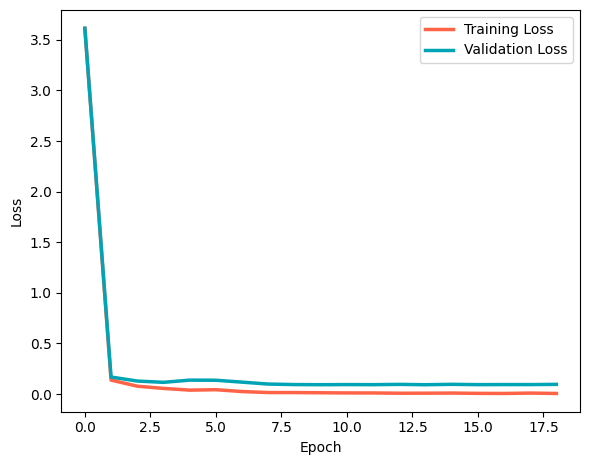

                            precision    recall  f1-score   support

                Abyssinian       0.91      0.94      0.92        98
          American Bulldog       0.83      0.95      0.89       100
 American Pit Bull Terrier       0.88      0.68      0.77       100
              Basset Hound       0.99      0.92      0.95       100
                    Beagle       0.93      0.99      0.96       100
                    Bengal       0.84      0.92      0.88       100
                    Birman       0.79      0.88      0.83       100
                    Bombay       0.84      0.99      0.91        88
                     Boxer       0.91      0.94      0.93        99
         British Shorthair       0.98      0.85      0.91       100
                 Chihuahua       0.95      0.95      0.95       100
              Egyptian Mau       0.89      0.91      0.90        97
    English Cocker Spaniel       0.99      1.00      1.00       100
            English Setter       1.00      0.99

Epoch 1/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 1, Training Loss: 0.159560 	 Validation Loss: 0.225998


Epoch 2/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 2, Training Loss: 0.088323 	 Validation Loss: 0.169782


Epoch 3/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 3, Training Loss: 0.051020 	 Validation Loss: 0.128073


Epoch 4/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 4, Training Loss: 0.054510 	 Validation Loss: 0.144948
Accuracy of Val: 0.9579
Accuracy of Test: 0.9210


Epoch 5/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 5, Training Loss: 0.019821 	 Validation Loss: 0.125327


Epoch 6/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 6, Training Loss: 0.017615 	 Validation Loss: 0.119715


Epoch 7/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 7, Training Loss: 0.017895 	 Validation Loss: 0.121450


Epoch 8/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 8, Training Loss: 0.017624 	 Validation Loss: 0.124642
Accuracy of Val: 0.9552
Accuracy of Test: 0.9406


Epoch 9/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 9, Training Loss: 0.019495 	 Validation Loss: 0.125287


Epoch 10/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 10, Training Loss: 0.018858 	 Validation Loss: 0.123064


Epoch 11/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 11, Training Loss: 0.0193 	 Validation Loss: 0.1203. Early stopping triggered
Training finished in 1848.38 seconds
Accuracy of Val: 0.9552
Accuracy of Test: 0.9422


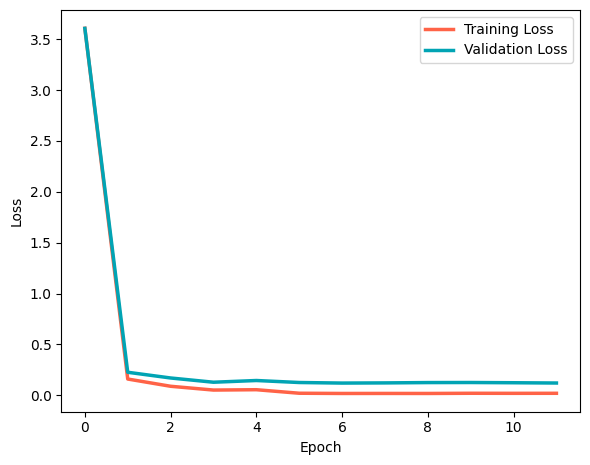

                            precision    recall  f1-score   support

                Abyssinian       0.98      0.91      0.94        98
          American Bulldog       0.80      0.90      0.85       100
 American Pit Bull Terrier       0.85      0.61      0.71       100
              Basset Hound       0.98      0.94      0.96       100
                    Beagle       0.95      0.97      0.96       100
                    Bengal       0.77      0.95      0.85       100
                    Birman       0.82      0.93      0.87       100
                    Bombay       0.87      0.98      0.92        88
                     Boxer       0.92      0.93      0.92        99
         British Shorthair       0.99      0.89      0.94       100
                 Chihuahua       0.92      0.95      0.94       100
              Egyptian Mau       0.90      0.93      0.91        97
    English Cocker Spaniel       0.99      1.00      1.00       100
            English Setter       1.00      0.99

Epoch 1/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 1, Training Loss: 0.168234 	 Validation Loss: 0.220615


Epoch 2/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 2, Training Loss: 0.084178 	 Validation Loss: 0.183478


Epoch 3/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 3, Training Loss: 0.056802 	 Validation Loss: 0.152050


Epoch 4/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 4, Training Loss: 0.029418 	 Validation Loss: 0.130296
Accuracy of Val: 0.9647
Accuracy of Test: 0.9302


Epoch 5/24: 100%|██████████| 184/184 [01:24<00:00,  2.17batch/s]


Epoch 5, Training Loss: 0.023502 	 Validation Loss: 0.134050


Epoch 6/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 6, Training Loss: 0.030468 	 Validation Loss: 0.167185


Epoch 7/24: 100%|██████████| 184/184 [01:24<00:00,  2.17batch/s]


Epoch 7, Training Loss: 0.008472 	 Validation Loss: 0.115794


Epoch 8/24: 100%|██████████| 184/184 [01:24<00:00,  2.17batch/s]


Epoch 8, Training Loss: 0.010724 	 Validation Loss: 0.118671
Accuracy of Val: 0.9633
Accuracy of Test: 0.9354


Epoch 9/24: 100%|██████████| 184/184 [01:26<00:00,  2.14batch/s]


Epoch 9, Training Loss: 0.008090 	 Validation Loss: 0.112349


Epoch 10/24: 100%|██████████| 184/184 [01:25<00:00,  2.15batch/s]


Epoch 10, Training Loss: 0.007448 	 Validation Loss: 0.111318


Epoch 11/24: 100%|██████████| 184/184 [01:25<00:00,  2.15batch/s]


Epoch 11, Training Loss: 0.007012 	 Validation Loss: 0.109749


Epoch 12/24: 100%|██████████| 184/184 [01:25<00:00,  2.14batch/s]


Epoch 12, Training Loss: 0.006204 	 Validation Loss: 0.107936
Accuracy of Val: 0.9688
Accuracy of Test: 0.9414


Epoch 13/24: 100%|██████████| 184/184 [01:26<00:00,  2.13batch/s]


Epoch 13, Training Loss: 0.006127 	 Validation Loss: 0.109057


Epoch 14/24: 100%|██████████| 184/184 [01:26<00:00,  2.13batch/s]


Epoch 14, Training Loss: 0.007520 	 Validation Loss: 0.107155


Epoch 15/24: 100%|██████████| 184/184 [01:26<00:00,  2.13batch/s]


Epoch 15, Training Loss: 0.005701 	 Validation Loss: 0.110414


Epoch 16/24: 100%|██████████| 184/184 [01:26<00:00,  2.13batch/s]


Epoch 16, Training Loss: 0.006604 	 Validation Loss: 0.106462
Accuracy of Val: 0.9688
Accuracy of Test: 0.9419


Epoch 17/24: 100%|██████████| 184/184 [01:27<00:00,  2.11batch/s]


Epoch 17, Training Loss: 0.009741 	 Validation Loss: 0.108706


Epoch 18/24: 100%|██████████| 184/184 [01:27<00:00,  2.11batch/s]


Epoch 18, Training Loss: 0.005026 	 Validation Loss: 0.101674


Epoch 19/24: 100%|██████████| 184/184 [01:27<00:00,  2.11batch/s]


Epoch 19, Training Loss: 0.008040 	 Validation Loss: 0.110556


Epoch 20/24: 100%|██████████| 184/184 [01:27<00:00,  2.11batch/s]


Epoch 20, Training Loss: 0.007512 	 Validation Loss: 0.109442
Accuracy of Val: 0.9674
Accuracy of Test: 0.9409


Epoch 21/24: 100%|██████████| 184/184 [01:27<00:00,  2.10batch/s]


Epoch 21, Training Loss: 0.005189 	 Validation Loss: 0.106116


Epoch 22/24: 100%|██████████| 184/184 [01:27<00:00,  2.09batch/s]


Epoch 22, Training Loss: 0.005134 	 Validation Loss: 0.105469


Epoch 23/24: 100%|██████████| 184/184 [01:27<00:00,  2.10batch/s]


Epoch 23, Training Loss: 0.0071 	 Validation Loss: 0.1058. Early stopping triggered
Training finished in 3957.69 seconds
Accuracy of Val: 0.9688
Accuracy of Test: 0.9409


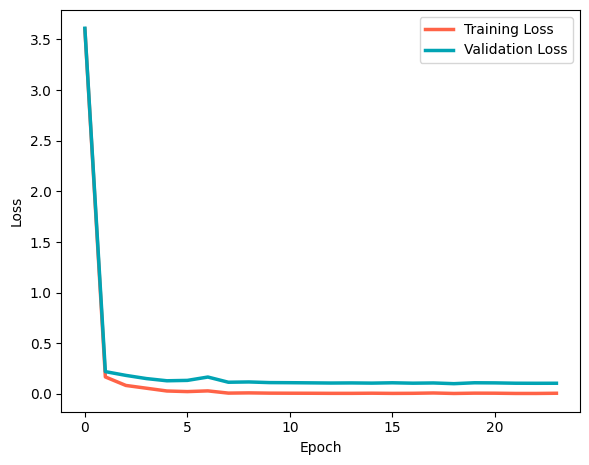

                            precision    recall  f1-score   support

                Abyssinian       0.94      0.95      0.94        98
          American Bulldog       0.78      0.95      0.86       100
 American Pit Bull Terrier       0.84      0.65      0.73       100
              Basset Hound       0.99      0.95      0.97       100
                    Beagle       0.96      0.98      0.97       100
                    Bengal       0.83      0.91      0.87       100
                    Birman       0.81      0.89      0.85       100
                    Bombay       0.86      1.00      0.93        88
                     Boxer       0.94      0.93      0.93        99
         British Shorthair       0.99      0.86      0.92       100
                 Chihuahua       0.93      0.95      0.94       100
              Egyptian Mau       0.92      0.93      0.92        97
    English Cocker Spaniel       0.99      1.00      1.00       100
            English Setter       1.00      0.99

Epoch 1/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 1, Training Loss: 0.145347 	 Validation Loss: 0.185453


Epoch 2/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 2, Training Loss: 0.082889 	 Validation Loss: 0.165185


Epoch 3/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 3, Training Loss: 0.074570 	 Validation Loss: 0.165775


Epoch 4/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 4, Training Loss: 0.040030 	 Validation Loss: 0.136722
Accuracy of Val: 0.9592
Accuracy of Test: 0.9321


Epoch 5/24: 100%|██████████| 184/184 [01:24<00:00,  2.17batch/s]


Epoch 5, Training Loss: 0.030452 	 Validation Loss: 0.141737


Epoch 6/24: 100%|██████████| 184/184 [01:24<00:00,  2.17batch/s]


Epoch 6, Training Loss: 0.027807 	 Validation Loss: 0.144812


Epoch 7/24: 100%|██████████| 184/184 [01:25<00:00,  2.14batch/s]


Epoch 7, Training Loss: 0.012248 	 Validation Loss: 0.106425


Epoch 8/24: 100%|██████████| 184/184 [01:25<00:00,  2.15batch/s]


Epoch 8, Training Loss: 0.013081 	 Validation Loss: 0.106165
Accuracy of Val: 0.9633
Accuracy of Test: 0.9376


Epoch 9/24: 100%|██████████| 184/184 [01:26<00:00,  2.13batch/s]


Epoch 9, Training Loss: 0.010262 	 Validation Loss: 0.097754


Epoch 10/24: 100%|██████████| 184/184 [01:26<00:00,  2.13batch/s]


Epoch 10, Training Loss: 0.008710 	 Validation Loss: 0.097971


Epoch 11/24: 100%|██████████| 184/184 [01:27<00:00,  2.11batch/s]


Epoch 11, Training Loss: 0.006517 	 Validation Loss: 0.094530


Epoch 12/24: 100%|██████████| 184/184 [01:27<00:00,  2.11batch/s]


Epoch 12, Training Loss: 0.006335 	 Validation Loss: 0.095676
Accuracy of Val: 0.9660
Accuracy of Test: 0.9406


Epoch 13/24: 100%|██████████| 184/184 [01:27<00:00,  2.10batch/s]


Epoch 13, Training Loss: 0.007011 	 Validation Loss: 0.100505


Epoch 14/24: 100%|██████████| 184/184 [01:27<00:00,  2.10batch/s]


Epoch 14, Training Loss: 0.009371 	 Validation Loss: 0.096446


Epoch 15/24: 100%|██████████| 184/184 [01:27<00:00,  2.10batch/s]


Epoch 15, Training Loss: 0.006674 	 Validation Loss: 0.099917


Epoch 16/24: 100%|██████████| 184/184 [01:27<00:00,  2.10batch/s]


Epoch 16, Training Loss: 0.0048 	 Validation Loss: 0.0950. Early stopping triggered
Training finished in 2728.70 seconds
Accuracy of Val: 0.9660
Accuracy of Test: 0.9422


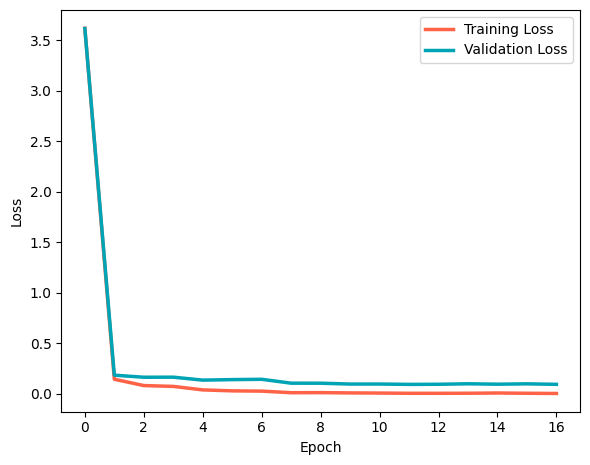

                            precision    recall  f1-score   support

                Abyssinian       0.94      0.95      0.94        98
          American Bulldog       0.80      0.95      0.87       100
 American Pit Bull Terrier       0.93      0.65      0.76       100
              Basset Hound       0.99      0.94      0.96       100
                    Beagle       0.95      0.97      0.96       100
                    Bengal       0.84      0.92      0.88       100
                    Birman       0.80      0.86      0.83       100
                    Bombay       0.84      0.97      0.90        88
                     Boxer       0.94      0.92      0.93        99
         British Shorthair       0.98      0.82      0.89       100
                 Chihuahua       0.93      0.97      0.95       100
              Egyptian Mau       0.89      0.94      0.91        97
    English Cocker Spaniel       0.98      0.99      0.99       100
            English Setter       1.00      0.98

Epoch 1/24: 100%|██████████| 184/184 [00:34<00:00,  5.26batch/s]


Epoch 1, Training Loss: 0.447560 	 Validation Loss: 0.507545


Epoch 2/24: 100%|██████████| 184/184 [00:35<00:00,  5.23batch/s]


Epoch 2, Training Loss: 0.252461 	 Validation Loss: 0.342011


Epoch 3/24: 100%|██████████| 184/184 [00:35<00:00,  5.24batch/s]


Epoch 3, Training Loss: 0.182736 	 Validation Loss: 0.278894


Epoch 4/24: 100%|██████████| 184/184 [00:35<00:00,  5.21batch/s]


Epoch 4, Training Loss: 0.105519 	 Validation Loss: 0.210518
Accuracy of Val: 0.9293
Accuracy of Test: 0.9109


Epoch 5/24: 100%|██████████| 184/184 [00:35<00:00,  5.21batch/s]


Epoch 5, Training Loss: 0.101115 	 Validation Loss: 0.228158


Epoch 6/24: 100%|██████████| 184/184 [00:35<00:00,  5.24batch/s]


Epoch 6, Training Loss: 0.058372 	 Validation Loss: 0.183229


Epoch 7/24: 100%|██████████| 184/184 [00:36<00:00,  5.04batch/s]


Epoch 7, Training Loss: 0.054013 	 Validation Loss: 0.182474


Epoch 8/24: 100%|██████████| 184/184 [00:36<00:00,  5.06batch/s]


Epoch 8, Training Loss: 0.055013 	 Validation Loss: 0.169311
Accuracy of Val: 0.9348
Accuracy of Test: 0.9171


Epoch 9/24: 100%|██████████| 184/184 [00:36<00:00,  5.06batch/s]


Epoch 9, Training Loss: 0.048579 	 Validation Loss: 0.172685


Epoch 10/24: 100%|██████████| 184/184 [00:37<00:00,  4.92batch/s]


Epoch 10, Training Loss: 0.047249 	 Validation Loss: 0.168882


Epoch 11/24: 100%|██████████| 184/184 [00:37<00:00,  4.91batch/s]


Epoch 11, Training Loss: 0.047580 	 Validation Loss: 0.154158


Epoch 12/24: 100%|██████████| 184/184 [00:37<00:00,  4.89batch/s]


Epoch 12, Training Loss: 0.045611 	 Validation Loss: 0.164263
Accuracy of Val: 0.9402
Accuracy of Test: 0.9226


Epoch 13/24: 100%|██████████| 184/184 [00:38<00:00,  4.72batch/s]


Epoch 13, Training Loss: 0.047655 	 Validation Loss: 0.179563


Epoch 14/24: 100%|██████████| 184/184 [00:39<00:00,  4.69batch/s]


Epoch 14, Training Loss: 0.043577 	 Validation Loss: 0.157204


Epoch 15/24: 100%|██████████| 184/184 [00:38<00:00,  4.77batch/s]


Epoch 15, Training Loss: 0.046911 	 Validation Loss: 0.180890


Epoch 16/24: 100%|██████████| 184/184 [00:39<00:00,  4.61batch/s]


Epoch 16, Training Loss: 0.0472 	 Validation Loss: 0.1595. Early stopping triggered
Training finished in 1947.62 seconds
Accuracy of Val: 0.9416
Accuracy of Test: 0.9229


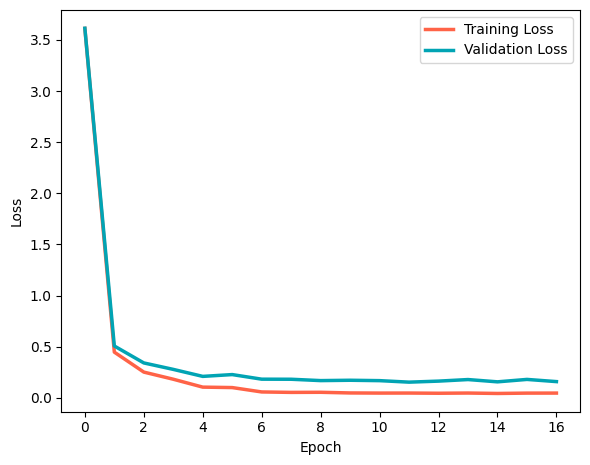

                            precision    recall  f1-score   support

                Abyssinian       0.91      0.87      0.89        98
          American Bulldog       0.80      0.92      0.86       100
 American Pit Bull Terrier       0.88      0.53      0.66       100
              Basset Hound       0.97      0.95      0.96       100
                    Beagle       0.95      0.96      0.96       100
                    Bengal       0.79      0.90      0.84       100
                    Birman       0.79      0.81      0.80       100
                    Bombay       0.86      0.97      0.91        88
                     Boxer       0.86      0.93      0.89        99
         British Shorthair       0.93      0.84      0.88       100
                 Chihuahua       0.90      0.92      0.91       100
              Egyptian Mau       0.88      0.91      0.89        97
    English Cocker Spaniel       0.98      0.97      0.97       100
            English Setter       1.00      0.98

Epoch 1/24: 100%|██████████| 184/184 [00:35<00:00,  5.23batch/s]


Epoch 1, Training Loss: 0.448786 	 Validation Loss: 0.481338


Epoch 2/24: 100%|██████████| 184/184 [00:35<00:00,  5.24batch/s]


Epoch 2, Training Loss: 0.251103 	 Validation Loss: 0.299364


Epoch 3/24: 100%|██████████| 184/184 [00:34<00:00,  5.28batch/s]


Epoch 3, Training Loss: 0.184859 	 Validation Loss: 0.250994


Epoch 4/24: 100%|██████████| 184/184 [00:35<00:00,  5.22batch/s]


Epoch 4, Training Loss: 0.134601 	 Validation Loss: 0.215340
Accuracy of Val: 0.9334
Accuracy of Test: 0.9144


Epoch 5/24: 100%|██████████| 184/184 [00:35<00:00,  5.25batch/s]


Epoch 5, Training Loss: 0.134466 	 Validation Loss: 0.234115


Epoch 6/24: 100%|██████████| 184/184 [00:34<00:00,  5.27batch/s]


Epoch 6, Training Loss: 0.100492 	 Validation Loss: 0.203783


Epoch 7/24: 100%|██████████| 184/184 [00:34<00:00,  5.27batch/s]


Epoch 7, Training Loss: 0.099786 	 Validation Loss: 0.185814


Epoch 8/24: 100%|██████████| 184/184 [00:34<00:00,  5.29batch/s]


Epoch 8, Training Loss: 0.087130 	 Validation Loss: 0.193276
Accuracy of Val: 0.9334
Accuracy of Test: 0.9103


Epoch 9/24: 100%|██████████| 184/184 [00:34<00:00,  5.31batch/s]


Epoch 9, Training Loss: 0.088853 	 Validation Loss: 0.186702


Epoch 10/24: 100%|██████████| 184/184 [00:34<00:00,  5.29batch/s]


Epoch 10, Training Loss: 0.084090 	 Validation Loss: 0.187984


Epoch 11/24: 100%|██████████| 184/184 [00:35<00:00,  5.24batch/s]


Epoch 11, Training Loss: 0.081770 	 Validation Loss: 0.184747


Epoch 12/24: 100%|██████████| 184/184 [00:34<00:00,  5.30batch/s]


Epoch 12, Training Loss: 0.079119 	 Validation Loss: 0.176160
Accuracy of Val: 0.9457
Accuracy of Test: 0.9171


Epoch 13/24: 100%|██████████| 184/184 [00:34<00:00,  5.30batch/s]


Epoch 13, Training Loss: 0.080385 	 Validation Loss: 0.181397


Epoch 14/24: 100%|██████████| 184/184 [00:34<00:00,  5.31batch/s]


Epoch 14, Training Loss: 0.088601 	 Validation Loss: 0.184505


Epoch 15/24: 100%|██████████| 184/184 [00:34<00:00,  5.32batch/s]


Epoch 15, Training Loss: 0.082634 	 Validation Loss: 0.191046


Epoch 16/24: 100%|██████████| 184/184 [00:34<00:00,  5.26batch/s]


Epoch 16, Training Loss: 0.080244 	 Validation Loss: 0.179386
Accuracy of Val: 0.9416
Accuracy of Test: 0.9141


Epoch 17/24: 100%|██████████| 184/184 [00:35<00:00,  5.21batch/s]


Epoch 17, Training Loss: 0.0814 	 Validation Loss: 0.1778. Early stopping triggered
Training finished in 2085.94 seconds
Accuracy of Val: 0.9416
Accuracy of Test: 0.9128


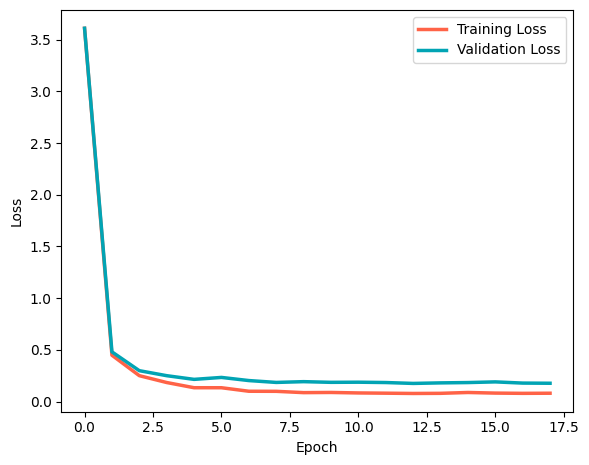

                            precision    recall  f1-score   support

                Abyssinian       0.90      0.89      0.89        98
          American Bulldog       0.81      0.88      0.84       100
 American Pit Bull Terrier       0.84      0.48      0.61       100
              Basset Hound       0.97      0.91      0.94       100
                    Beagle       0.93      0.97      0.95       100
                    Bengal       0.73      0.82      0.77       100
                    Birman       0.76      0.82      0.79       100
                    Bombay       0.84      0.97      0.90        88
                     Boxer       0.84      0.94      0.89        99
         British Shorthair       0.94      0.75      0.83       100
                 Chihuahua       0.89      0.96      0.92       100
              Egyptian Mau       0.83      0.88      0.85        97
    English Cocker Spaniel       0.98      0.93      0.95       100
            English Setter       0.96      0.98

Epoch 1/24: 100%|██████████| 184/184 [00:34<00:00,  5.29batch/s]


Epoch 1, Training Loss: 0.446131 	 Validation Loss: 0.495524


Epoch 2/24: 100%|██████████| 184/184 [00:34<00:00,  5.26batch/s]


Epoch 2, Training Loss: 0.259478 	 Validation Loss: 0.339359


Epoch 3/24: 100%|██████████| 184/184 [00:34<00:00,  5.32batch/s]


Epoch 3, Training Loss: 0.177015 	 Validation Loss: 0.278470


Epoch 4/24: 100%|██████████| 184/184 [00:34<00:00,  5.29batch/s]


Epoch 4, Training Loss: 0.144620 	 Validation Loss: 0.256352
Accuracy of Val: 0.9212
Accuracy of Test: 0.9049


Epoch 5/24: 100%|██████████| 184/184 [00:34<00:00,  5.32batch/s]


Epoch 5, Training Loss: 0.130053 	 Validation Loss: 0.236816


Epoch 6/24: 100%|██████████| 184/184 [00:34<00:00,  5.28batch/s]


Epoch 6, Training Loss: 0.133647 	 Validation Loss: 0.249866


Epoch 7/24: 100%|██████████| 184/184 [00:34<00:00,  5.28batch/s]


Epoch 7, Training Loss: 0.121293 	 Validation Loss: 0.237174


Epoch 8/24: 100%|██████████| 184/184 [00:34<00:00,  5.29batch/s]


Epoch 8, Training Loss: 0.116522 	 Validation Loss: 0.232181
Accuracy of Val: 0.9361
Accuracy of Test: 0.9150


Epoch 9/24: 100%|██████████| 184/184 [00:34<00:00,  5.30batch/s]


Epoch 9, Training Loss: 0.122859 	 Validation Loss: 0.235935


Epoch 10/24: 100%|██████████| 184/184 [00:34<00:00,  5.31batch/s]


Epoch 10, Training Loss: 0.123138 	 Validation Loss: 0.231579


Epoch 11/24: 100%|██████████| 184/184 [00:34<00:00,  5.29batch/s]


Epoch 11, Training Loss: 0.119553 	 Validation Loss: 0.233259


Epoch 12/24: 100%|██████████| 184/184 [00:35<00:00,  5.23batch/s]


Epoch 12, Training Loss: 0.114897 	 Validation Loss: 0.225783
Accuracy of Val: 0.9402
Accuracy of Test: 0.9150


Epoch 13/24: 100%|██████████| 184/184 [00:35<00:00,  5.20batch/s]


Epoch 13, Training Loss: 0.114859 	 Validation Loss: 0.233302


Epoch 14/24: 100%|██████████| 184/184 [00:35<00:00,  5.25batch/s]


Epoch 14, Training Loss: 0.110968 	 Validation Loss: 0.230729


Epoch 15/24: 100%|██████████| 184/184 [00:35<00:00,  5.25batch/s]


Epoch 15, Training Loss: 0.116872 	 Validation Loss: 0.224044


Epoch 16/24: 100%|██████████| 184/184 [00:34<00:00,  5.29batch/s]


Epoch 16, Training Loss: 0.111346 	 Validation Loss: 0.227866
Accuracy of Val: 0.9402
Accuracy of Test: 0.9147


Epoch 17/24: 100%|██████████| 184/184 [00:35<00:00,  5.16batch/s]


Epoch 17, Training Loss: 0.111810 	 Validation Loss: 0.231644


Epoch 18/24: 100%|██████████| 184/184 [00:35<00:00,  5.12batch/s]


Epoch 18, Training Loss: 0.114421 	 Validation Loss: 0.228109


Epoch 19/24: 100%|██████████| 184/184 [00:35<00:00,  5.16batch/s]


Epoch 19, Training Loss: 0.114265 	 Validation Loss: 0.224725


Epoch 20/24: 100%|██████████| 184/184 [00:34<00:00,  5.27batch/s]


Epoch 20, Training Loss: 0.1207 	 Validation Loss: 0.2289. Early stopping triggered
Training finished in 2407.86 seconds
Accuracy of Val: 0.9334
Accuracy of Test: 0.9180


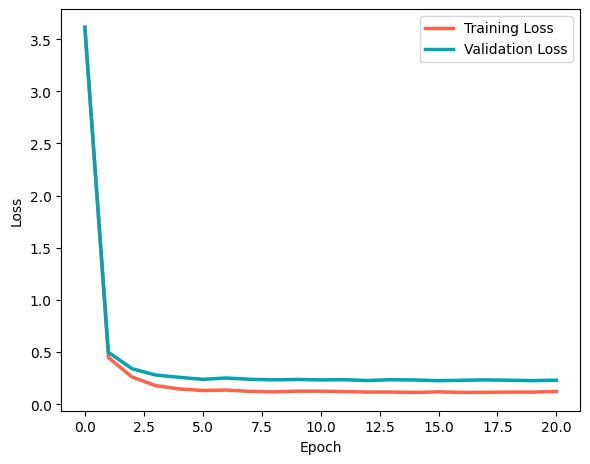

                            precision    recall  f1-score   support

                Abyssinian       0.90      0.88      0.89        98
          American Bulldog       0.81      0.97      0.88       100
 American Pit Bull Terrier       0.86      0.61      0.71       100
              Basset Hound       0.98      0.95      0.96       100
                    Beagle       0.96      0.97      0.97       100
                    Bengal       0.75      0.84      0.79       100
                    Birman       0.78      0.86      0.82       100
                    Bombay       0.83      0.98      0.90        88
                     Boxer       0.89      0.92      0.91        99
         British Shorthair       0.89      0.75      0.82       100
                 Chihuahua       0.89      0.95      0.92       100
              Egyptian Mau       0.83      0.88      0.85        97
    English Cocker Spaniel       0.96      0.97      0.97       100
            English Setter       0.98      0.99

Epoch 1/24: 100%|██████████| 184/184 [00:36<00:00,  5.10batch/s]


Epoch 1, Training Loss: 0.453299 	 Validation Loss: 0.472435


Epoch 2/24: 100%|██████████| 184/184 [00:36<00:00,  5.09batch/s]


Epoch 2, Training Loss: 0.248351 	 Validation Loss: 0.315278


Epoch 3/24: 100%|██████████| 184/184 [00:35<00:00,  5.13batch/s]


Epoch 3, Training Loss: 0.179948 	 Validation Loss: 0.253741


Epoch 4/24: 100%|██████████| 184/184 [00:35<00:00,  5.15batch/s]


Epoch 4, Training Loss: 0.142008 	 Validation Loss: 0.216101
Accuracy of Val: 0.9429
Accuracy of Test: 0.9139


Epoch 5/24: 100%|██████████| 184/184 [00:35<00:00,  5.14batch/s]


Epoch 5, Training Loss: 0.133695 	 Validation Loss: 0.211467


Epoch 6/24: 100%|██████████| 184/184 [00:35<00:00,  5.14batch/s]


Epoch 6, Training Loss: 0.127970 	 Validation Loss: 0.214644


Epoch 7/24: 100%|██████████| 184/184 [00:35<00:00,  5.15batch/s]


Epoch 7, Training Loss: 0.127867 	 Validation Loss: 0.210353


Epoch 8/24: 100%|██████████| 184/184 [00:35<00:00,  5.15batch/s]


Epoch 8, Training Loss: 0.126221 	 Validation Loss: 0.209776
Accuracy of Val: 0.9416
Accuracy of Test: 0.9161


Epoch 9/24: 100%|██████████| 184/184 [00:35<00:00,  5.22batch/s]


Epoch 9, Training Loss: 0.129310 	 Validation Loss: 0.217827


Epoch 10/24: 100%|██████████| 184/184 [00:34<00:00,  5.28batch/s]


Epoch 10, Training Loss: 0.124465 	 Validation Loss: 0.217071


Epoch 11/24: 100%|██████████| 184/184 [00:35<00:00,  5.25batch/s]


Epoch 11, Training Loss: 0.121749 	 Validation Loss: 0.213018


Epoch 12/24: 100%|██████████| 184/184 [00:35<00:00,  5.20batch/s]


Epoch 12, Training Loss: 0.124576 	 Validation Loss: 0.210927
Accuracy of Val: 0.9457
Accuracy of Test: 0.9141


Epoch 13/24: 100%|██████████| 184/184 [00:34<00:00,  5.30batch/s]


Epoch 13, Training Loss: 0.121750 	 Validation Loss: 0.207003


Epoch 14/24: 100%|██████████| 184/184 [00:34<00:00,  5.27batch/s]


Epoch 14, Training Loss: 0.131794 	 Validation Loss: 0.211628


Epoch 15/24: 100%|██████████| 184/184 [00:34<00:00,  5.26batch/s]


Epoch 15, Training Loss: 0.121535 	 Validation Loss: 0.213467


Epoch 16/24: 100%|██████████| 184/184 [00:34<00:00,  5.28batch/s]


Epoch 16, Training Loss: 0.122908 	 Validation Loss: 0.208138
Accuracy of Val: 0.9429
Accuracy of Test: 0.9152


Epoch 17/24: 100%|██████████| 184/184 [00:34<00:00,  5.26batch/s]


Epoch 17, Training Loss: 0.130275 	 Validation Loss: 0.215402


Epoch 18/24: 100%|██████████| 184/184 [00:34<00:00,  5.27batch/s]


Epoch 18, Training Loss: 0.1220 	 Validation Loss: 0.2116. Early stopping triggered
Training finished in 2203.17 seconds
Accuracy of Val: 0.9416
Accuracy of Test: 0.9155


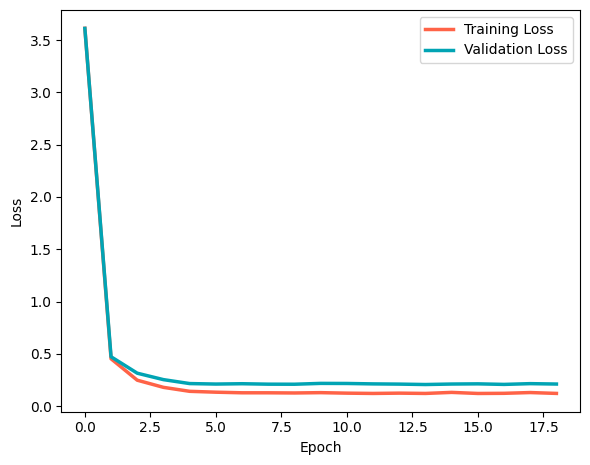

                            precision    recall  f1-score   support

                Abyssinian       0.89      0.89      0.89        98
          American Bulldog       0.78      0.95      0.86       100
 American Pit Bull Terrier       0.90      0.44      0.59       100
              Basset Hound       0.96      0.94      0.95       100
                    Beagle       0.95      0.96      0.96       100
                    Bengal       0.76      0.91      0.83       100
                    Birman       0.77      0.88      0.82       100
                    Bombay       0.85      0.94      0.89        88
                     Boxer       0.86      0.92      0.89        99
         British Shorthair       0.94      0.72      0.81       100
                 Chihuahua       0.89      0.94      0.91       100
              Egyptian Mau       0.91      0.91      0.91        97
    English Cocker Spaniel       0.98      0.97      0.97       100
            English Setter       0.99      0.99

In [ ]:
testing = [(5e-3, 4, 6, 1), (5e-3, 2, 2, 1), (5e-3, 4, 6, 2), (5e-3, 2, 6, 2), (5e-3, 3, 6, 3), (5e-3, 2, 6, 0), (5e-3, 2, 4, 0), (5e-3, 2, 2, 0)]

for lr, unfreeze_interval, reduce_learning_rate, training_mode in testing:
    print(f"Training with parameters:")
    print(f"  Learning Rate: {lr}")
    print(f"  Unfreeze Interval: {unfreeze_interval}")
    print(f"  Reduce Learning Rate: {reduce_learning_rate}")
    print(f"  Training Mode: {training_mode}")
    train = Train(lr=lr, bs=16, epochs=24, split_ratio=0.8, model=None, unfreeze_interval=unfreeze_interval, _LoadData=_LoadData, change_of_learning_rate=10, reduce_learning_rate=reduce_learning_rate, training_mode=training_mode)
    train.train()
    train.evaluate(train.val_loader)
    train.evaluate(train.test_loader)
    train.plot_loss_curves()
    train.classification_report()
    print("-" * 40)